# Desafio 5

Neste desafio, vamos praticar sobre redução de dimensionalidade com PCA e seleção de variáveis com RFE. Utilizaremos o _data set_ [Fifa 2019](https://www.kaggle.com/karangadiya/fifa19), contendo originalmente 89 variáveis de mais de 18 mil jogadores do _game_ FIFA 2019.

> Obs.: Por favor, não modifique o nome das funções de resposta.

## _Setup_ geral

In [10]:
from math import sqrt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sct
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats as st
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import RFECV

In [4]:

from IPython.core.pylabtools import figsize


figsize(12, 8)

sns.set()

In [5]:
fifa = pd.read_csv("fifa.csv")

In [6]:
columns_to_drop = ["Unnamed: 0", "ID", "Name", "Photo", "Nationality", "Flag",
                   "Club", "Club Logo", "Value", "Wage", "Special", "Preferred Foot",
                   "International Reputation", "Weak Foot", "Skill Moves", "Work Rate",
                   "Body Type", "Real Face", "Position", "Jersey Number", "Joined",
                   "Loaned From", "Contract Valid Until", "Height", "Weight", "LS",
                   "ST", "RS", "LW", "LF", "CF", "RF", "RW", "LAM", "CAM", "RAM", "LM",
                   "LCM", "CM", "RCM", "RM", "LWB", "LDM", "CDM", "RDM", "RWB", "LB", "LCB",
                   "CB", "RCB", "RB", "Release Clause"
]

try:
    fifa.drop(columns_to_drop, axis=1, inplace=True)
except KeyError:
    logger.warning(f"Columns already dropped")

## Inicia sua análise a partir daqui


### Sobre PCA

https://www.youtube.com/watch?v=W0cZ6KzDLiw&t=2113s

### Sobre RFE

Sklearn RFE
Particulamente, eu curto bastante o RFE. O resultado dele é bem consistente, e seu principal trade-off — o tempo — não chega a ser uma fator tão negativo em meus projetos.
Assim como seu nome diz — Recursive Feature Elimination — , o RFE funciona da seguinte forma: ele irá treinar seu modelo utilizando todo seu conjunto inicial, com todas as features e data points que vierem nele. Após o primeiro treino, o RFE irá verificar a importâncias das features — utilizando atributos como coef_ ou feature_importances_ — e, recursivamente, irá remover as features menos importantes do dataset e treinar o modelo novamente. Ele fará isso até chegar a um número ideal de features. Veja abaixo uma aplicação do RFE, onde informo que quero remover uma feature de cada vez. Ou seja, cada vez que o modelo for treinado, ele irá remover uma feature. O parêmetro n_features_to_select pode ser passado para informar a quantidade de features que quer selecionar. Se ele for nulo, o RFE escolherá metade do total de features.

https://medium.com/data-hackers/como-selecionar-as-melhores-features-para-seu-modelo-de-machine-learning-faf74e357913

In [7]:
# Sua análise começa aqui.
fifa.columns

Index(['Age', 'Overall', 'Potential', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes'],
      dtype='object')

In [9]:
fifa.head(10)

,Age,Overall,Potential,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,31,94,94,84.0,95.0,70.0,90.0,86.0,97.0,93.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,33,94,94,84.0,94.0,89.0,81.0,87.0,88.0,81.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,26,92,93,79.0,87.0,62.0,84.0,84.0,96.0,88.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,27,91,93,17.0,13.0,21.0,50.0,13.0,18.0,21.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,27,91,92,93.0,82.0,55.0,92.0,82.0,86.0,85.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0
5,27,91,91,81.0,84.0,61.0,89.0,80.0,95.0,83.0,...,86.0,91.0,34.0,27.0,22.0,11.0,12.0,6.0,8.0,8.0
6,32,91,91,86.0,72.0,55.0,93.0,76.0,90.0,85.0,...,82.0,84.0,60.0,76.0,73.0,13.0,9.0,7.0,14.0,9.0
7,31,91,91,77.0,93.0,77.0,82.0,88.0,87.0,86.0,...,85.0,85.0,62.0,45.0,38.0,27.0,25.0,31.0,33.0,37.0
8,32,91,91,66.0,60.0,91.0,78.0,66.0,63.0,74.0,...,75.0,82.0,87.0,92.0,91.0,11.0,8.0,9.0,7.0,11.0
9,25,90,93,13.0,11.0,15.0,29.0,13.0,12.0,13.0,...,11.0,70.0,27.0,12.0,18.0,86.0,92.0,78.0,88.0,89.0


In [12]:
fifa.dtypes

Age                  int64
Overall              int64
Potential            int64
Crossing           float64
Finishing          float64
HeadingAccuracy    float64
ShortPassing       float64
Volleys            float64
Dribbling          float64
Curve              float64
FKAccuracy         float64
LongPassing        float64
BallControl        float64
Acceleration       float64
SprintSpeed        float64
Agility            float64
Reactions          float64
Balance            float64
ShotPower          float64
Jumping            float64
Stamina            float64
Strength           float64
LongShots          float64
Aggression         float64
Interceptions      float64
Positioning        float64
Vision             float64
Penalties          float64
Composure          float64
Marking            float64
StandingTackle     float64
SlidingTackle      float64
GKDiving           float64
GKHandling         float64
GKKicking          float64
GKPositioning      float64
GKReflexes         float64
d

In [25]:
(fifa.isna().sum() / fifa.shape[0]) * 100

Age                0.000000
Overall            0.000000
Potential          0.000000
Crossing           0.263635
Finishing          0.263635
HeadingAccuracy    0.263635
ShortPassing       0.263635
Volleys            0.263635
Dribbling          0.263635
Curve              0.263635
FKAccuracy         0.263635
LongPassing        0.263635
BallControl        0.263635
Acceleration       0.263635
SprintSpeed        0.263635
Agility            0.263635
Reactions          0.263635
Balance            0.263635
ShotPower          0.263635
Jumping            0.263635
Stamina            0.263635
Strength           0.263635
LongShots          0.263635
Aggression         0.263635
Interceptions      0.263635
Positioning        0.263635
Vision             0.263635
Penalties          0.263635
Composure          0.263635
Marking            0.263635
StandingTackle     0.263635
SlidingTackle      0.263635
GKDiving           0.263635
GKHandling         0.263635
GKKicking          0.263635
GKPositioning      0

In [49]:
fifa.describe()

,Age,Overall,Potential,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
count,18207.000000,18207.000000,18207.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,...,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000
mean,25.122206,66.238699,71.307299,49.734181,45.550911,52.298144,58.686712,42.909026,55.371001,47.170824,...,48.548598,58.648274,47.281623,47.697836,45.661435,16.616223,16.391596,16.232061,16.388898,16.710887
std,4.669943,6.908930,6.136496,18.364524,19.525820,17.379909,14.699495,17.694408,18.910371,18.395264,...,15.704053,11.436133,19.904397,21.664004,21.289135,17.695349,16.906900,16.502864,17.034669,17.955119
min,16.000000,46.000000,48.000000,5.000000,2.000000,4.000000,7.000000,4.000000,4.000000,6.000000,...,5.000000,3.000000,3.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,21.000000,62.000000,67.000000,38.000000,30.000000,44.000000,54.000000,30.000000,49.000000,34.000000,...,39.000000,51.000000,30.000000,27.000000,24.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,25.000000,66.000000,71.000000,54.000000,49.000000,56.000000,62.000000,44.000000,61.000000,48.000000,...,49.000000,60.000000,53.000000,55.000000,52.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,28.000000,71.000000,75.000000,64.000000,62.000000,64.000000,68.000000,57.000000,68.000000,62.000000,...,60.000000,67.000000,64.000000,66.000000,64.000000,14.000000,14.000000,14.000000,14.000000,14.000000
max,45.000000,94.000000,95.000000,93.000000,95.000000,94.000000,93.000000,90.000000,97.000000,94.000000,...,92.000000,96.000000,94.000000,93.000000,91.000000,90.000000,92.000000,91.000000,90.000000,94.000000


In [12]:
fifa.dropna(inplace=True)


## Questão 1

Qual fração da variância consegue ser explicada pelo primeiro componente principal de `fifa`? Responda como um único float (entre 0 e 1) arredondado para três casas decimais.

In [53]:
def q1():
    pca = PCA()
    pca.fit(fifa)
    return float(round(pca.explained_variance_ratio_[0],3))
    pass

## Questão 2

Quantos componentes principais precisamos para explicar 95% da variância total? Responda como un único escalar inteiro.

Text(0, 0.5, 'cumulative explained variance')

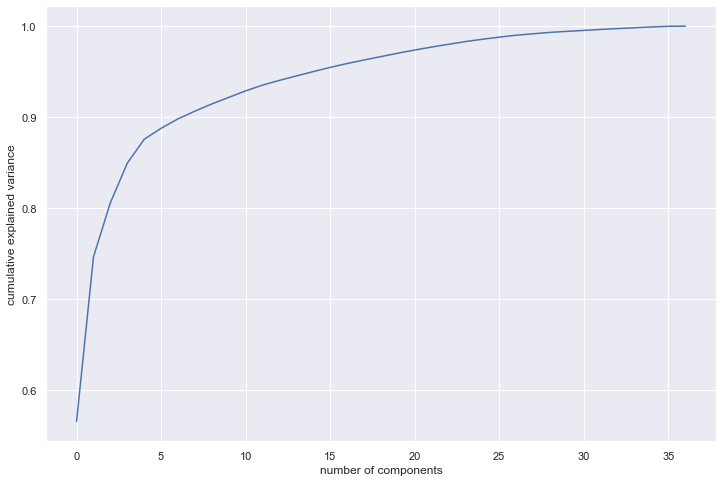

In [80]:
pca = PCA().fit(fifa)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [58]:
def q2():
    pca = PCA(0.95)
    pca.fit(fifa)
    return int(pca.n_components_)
    pass

In [79]:
q2()

15

## Questão 3

Qual são as coordenadas (primeiro e segundo componentes principais) do ponto `x` abaixo? O vetor abaixo já está centralizado. Cuidado para __não__ centralizar o vetor novamente (por exemplo, invocando `PCA.transform()` nele). Responda como uma tupla de float arredondados para três casas decimais.

In [60]:
x = [0.87747123,  -1.24990363,  -1.3191255, -36.7341814,
     -35.55091139, -37.29814417, -28.68671182, -30.90902583,
     -42.37100061, -32.17082438, -28.86315326, -22.71193348,
     -38.36945867, -20.61407566, -22.72696734, -25.50360703,
     2.16339005, -27.96657305, -33.46004736,  -5.08943224,
     -30.21994603,   3.68803348, -36.10997302, -30.86899058,
     -22.69827634, -37.95847789, -22.40090313, -30.54859849,
     -26.64827358, -19.28162344, -34.69783578, -34.6614351,
     48.38377664,  47.60840355,  45.76793876,  44.61110193,
     49.28911284
]

In [64]:
def q3(sample=x):
    pca = PCA(0.95)
    pca.fit(fifa)
    return tuple((pca.components_.dot(sample)[:2]).round(3))
    pass

In [65]:
q3()

(186.556, -6.592)

## Questão 4

Realiza RFE com estimador de regressão linear para selecionar cinco variáveis, eliminando uma a uma. Quais são as variáveis selecionadas? Responda como uma lista de nomes de variáveis.

In [77]:
def q4():
    x = fifa.drop(columns="Overall")
    y = fifa["Overall"]
    classifier = LinearRegression()
    feature_selector = RFE(classifier, n_features_to_select=5)
    feature_selector.fit(x, y)
    best_features = (feature_selector.get_support(indices=True))
    return list(x.iloc[0, best_features].index)
    pass

In [1]:
q4()

NameError: name 'q4' is not defined

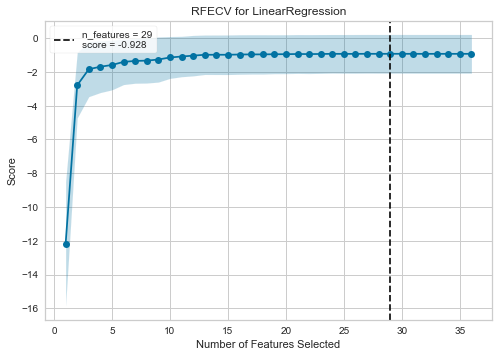

In [21]:
x = fifa.drop(columns="Overall")
y = fifa["Overall"]

reg = LinearRegression()
rfe = RFE(reg)

rfe.fit(x,y)
x_train_importante = rfe.transform(x)

reg.fit(x_train_importante,y)

visualizer = RFECV(classifier)
visualizer.fit(x, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure